This notebook shows examples of the filtered detections.

In [1]:
import sys
import os, errno
import os.path as osp
import logging
handler = logging.FileHandler(filename='important_log.log', mode='a')
sys.path.insert(0,'/users/cmofokeng/rgz_rcnn/tools/')

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits

from fuse_radio_ir import fuse

import cv2

In [2]:
# load full and filtered catalogues
data_full = pd.read_csv("/idia/users/cmofokeng/data/gmrt/output_gmrt/ClaRAN_D1_final_catalogue_v4.csv")
data_filtered = pd.read_csv("/idia/users/cmofokeng/data/gmrt/output_gmrt/ClaRAN_D1_edge_catalogue_v3.csv")

In [3]:
data_full["Source_ID"].nunique(), data_filtered["Source_ID"].nunique()

(4212, 3826)

In [4]:
random_df = data_filtered.sample(n=1)

In [5]:
random_df

,Source_ID,Class,Scores,x1,y1,x2,y2,RC_RA,RC_Dec,PyBDSF_RA,PyBDSF_Dec
4337,829,3C_3P,0.9695,245.3467,56.0094,245.3119,56.0316,245.3304,56.0192,245.3235,56.0265


In [6]:
data = data_filtered[data_filtered['Source_ID']==random_df['Source_ID'].iloc[0]]

In [7]:
data

,Source_ID,Class,Scores,x1,y1,x2,y2,RC_RA,RC_Dec,PyBDSF_RA,PyBDSF_Dec
4336,829,1C_1P,0.9630,245.3388,56.0126,245.3342,56.0157,245.3364,56.0141,245.3235,56.0265
4337,829,3C_3P,0.9695,245.3467,56.0094,245.3119,56.0316,245.3304,56.0192,245.3235,56.0265


In [8]:
data_df = data_full[data_full["Source_ID"]==random_df['Source_ID'].iloc[0]]

In [9]:
data_df

,Source_ID,Class,Scores,x1,y1,x2,y2,RC_RA,RC_Dec,PyBDSF_RA,PyBDSF_Dec
6898,829,1C_1P,0.9789,245.3676,56.0380,245.3533,56.0469,245.3603,56.0423,245.3235,56.0265
6899,829,1C_1P,0.9630,245.3388,56.0126,245.3342,56.0157,245.3364,56.0141,245.3235,56.0265
6900,829,3C_3P,0.9695,245.3467,56.0094,245.3119,56.0316,245.3304,56.0192,245.3235,56.0265


In [10]:
df_diff = pd.concat([data_df,data],sort=False).drop_duplicates(subset=['Class','x1','x2'],keep=False)

In [11]:
df_diff

,Source_ID,Class,Scores,x1,y1,x2,y2,RC_RA,RC_Dec,PyBDSF_RA,PyBDSF_Dec
6898,829,1C_1P,0.9789,245.3676,56.038,245.3533,56.0469,245.3603,56.0423,245.3235,56.0265


In [12]:
file_path = "gmrt_en1w610_clipped_" + str(data_df["Source_ID"].iloc[0]) + "_infrared.png"
#file_path = osp.basename(data_df["file_path"].iloc[0]).replace("_infraredctmask_pred.png","_infrared.png")

img = cv2.imread(osp.join("/idia/users/cmofokeng/data/gmrt/split_fits/test_1deg/",file_path))

In [13]:
fits_file = osp.join("/idia/users/cmofokeng/data/gmrt/split_fits/test_1deg/",file_path.replace("_infrared.png",".fits"))

In [14]:
with fits.open(fits_file) as file:
    hduradio = file[0]
    wcsradio = WCS(hduradio.header, naxis=2)
    fits_data = hduradio.data
        
    xscale = abs(hduradio.header['CDELT1'])
    yscale = abs(hduradio.header['CDELT2'])
            
    xpix = hduradio.header['NAXIS1']
    ypix = hduradio.header['NAXIS2']
            
    xsize = xscale*xpix
    ysize = yscale*ypix

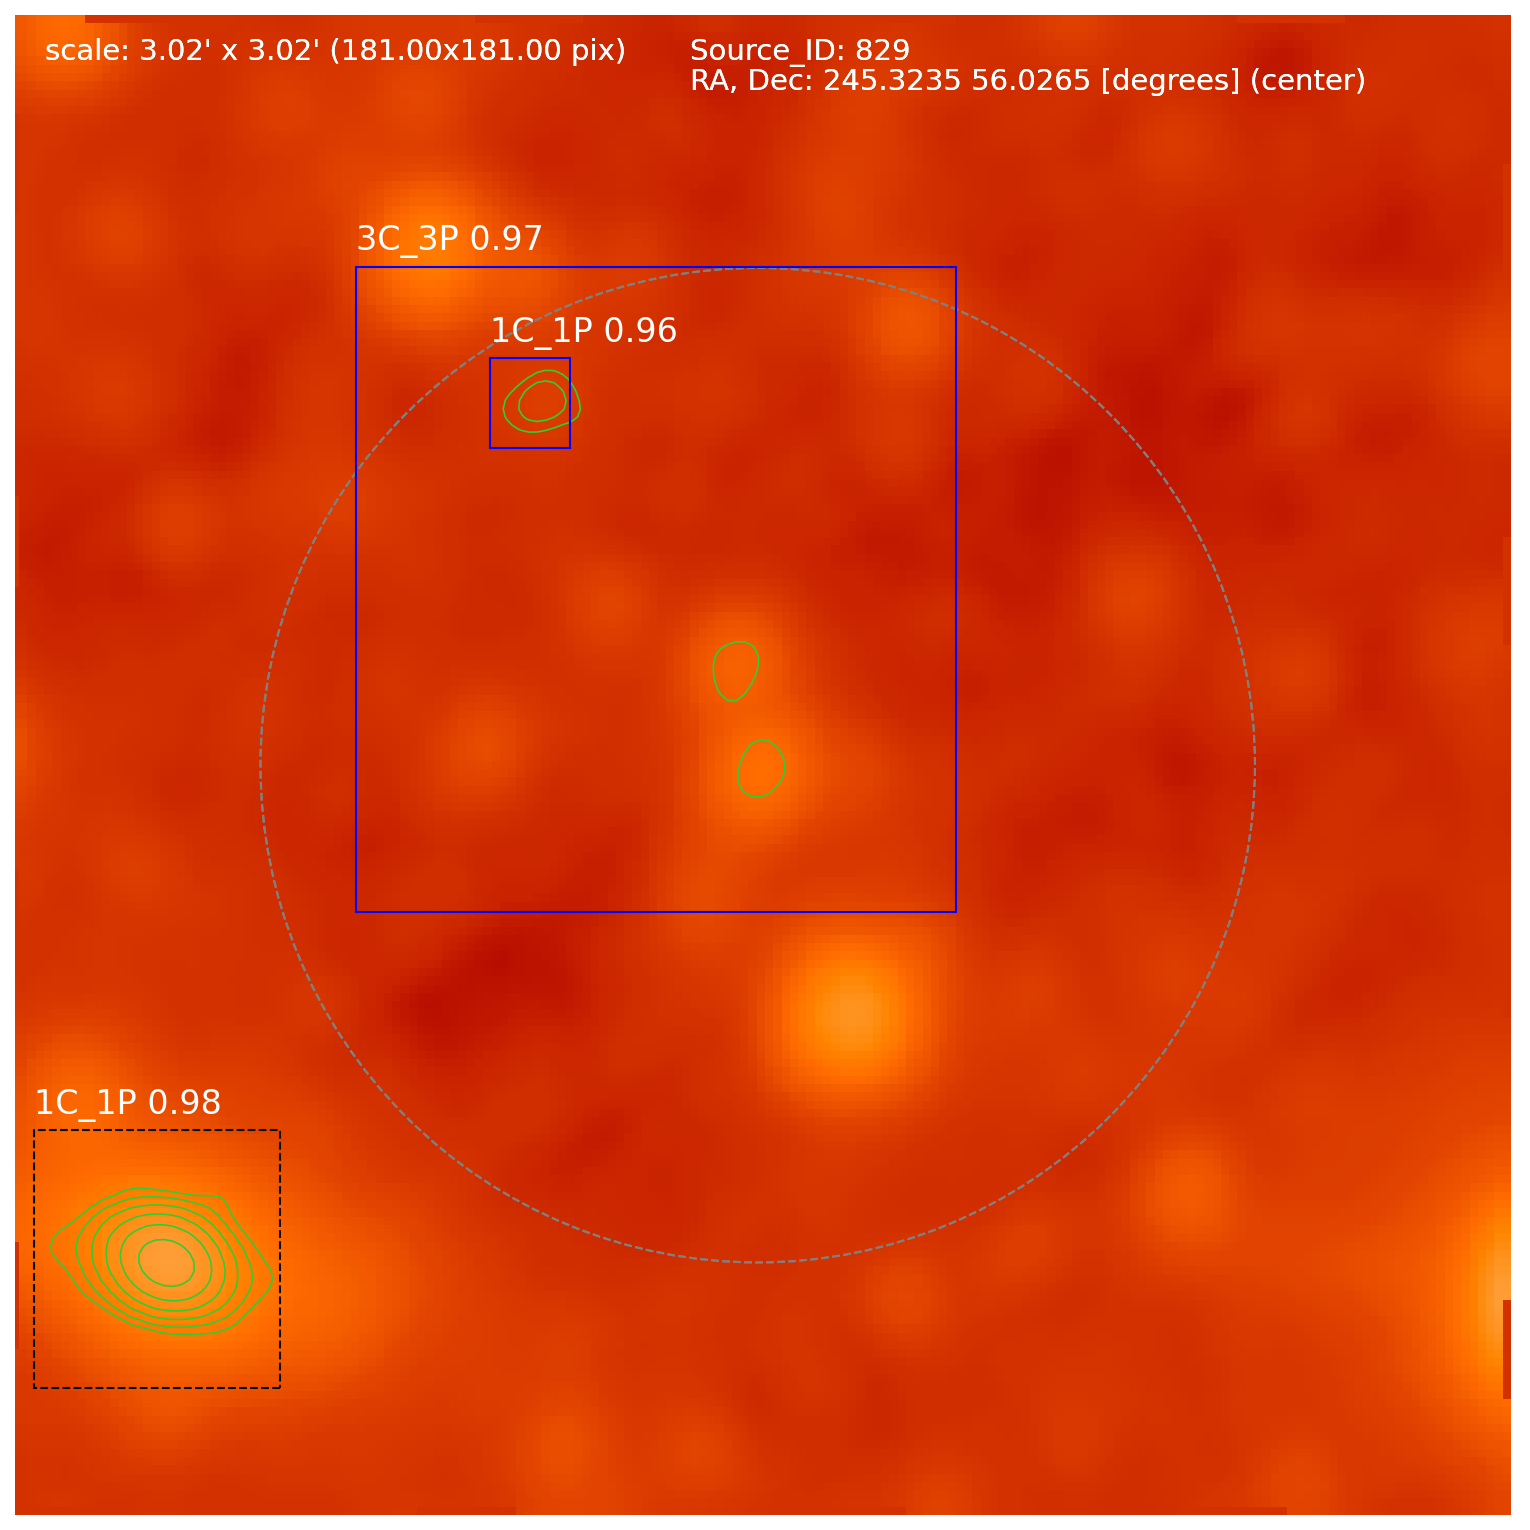

In [15]:
# Create matplotlib path for contours
patch_contour = fuse(fits_file, img, None, sigma_level=4, mask_ir=False,
                             get_path_patch_only=True)


fig = plt.figure(figsize=(10,10),dpi=150)

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_xlim([0, img.shape[0]])

ax.set_axis_off()
fig.add_axes(ax)
ax.set_aspect('equal')

im = img[:, :, (2, 1, 0)]
ax.imshow(im,origin='upper')
ax.add_patch(patch_contour)

for i in range(len(data)):
    
    row = data.iloc[i]
    
    # store coordinates of the bounding box as an instance of skycoord
    cp = SkyCoord(row['PyBDSF_RA'],row['PyBDSF_Dec'], frame='fk5', unit ='deg') # central position of the cutout

    # positions of the edges of the box
    ul = SkyCoord(row['x1'],row['y1'], frame='fk5', unit ='deg')
    
    lr = SkyCoord(row['x2'],row['y2'], frame='fk5', unit ='deg')
    
    # convert postions to pixel coordinates
    central_p = cp.to_pixel(wcsradio)
    upper_left = ul.to_pixel(wcsradio)
    lower_right = lr.to_pixel(wcsradio)
    
    w = upper_left[0] - lower_right[0]
    h = upper_left[1] - lower_right[1]
    ax.add_patch(plt.Circle((central_p[0], central_p[1]), 60, edgecolor='grey', facecolor='none', linestyle='--'))
    ax.add_patch(plt.Rectangle((lower_right[0], lower_right[1]), w, h, edgecolor='blue', facecolor='none'))

    ax.text(upper_left[0], upper_left[1] - 2,
                        '{:s} {:.2f}'.format(row['Class'], row['Scores']),
                        bbox=dict(facecolor='None', alpha=0.4, edgecolor='None'),
                        fontsize=16, color='white')
    
    source_ID = "Source_ID: " + str(row['Source_ID'])
    ax.annotate(source_ID, xy=(0.45,0.97), xycoords='axes fraction', color='w', fontsize=14)

    coords = "RA, Dec: {:.4f} {:.4f} [degrees] (center)".format(row['PyBDSF_RA'],row['PyBDSF_Dec'])
    ax.annotate(coords, xy=(0.45,0.95),xycoords='axes fraction', color='w', fontsize=14)


    scale = 1.0
    show_img_size = img.shape[0]

    scal = "scale: %.2f' x %.2f' (%.2fx%.2f pix)"%((xsize/scale)*60,(ysize/scale)*60,show_img_size,show_img_size)
    ax.annotate(scal, xy=(0.02,0.97), xycoords='axes fraction', color='w', fontsize=14)

# show dropped detections
for i in range(len(df_diff)):
    
    row = df_diff.iloc[i]

    # store coordinates of the bounding box as an instance of skycoord
    ul = SkyCoord(row['x1'],row['y1'], frame='fk5', unit ='deg')
    lr = SkyCoord(row['x2'],row['y2'], frame='fk5', unit ='deg')
    
    upper_left = ul.to_pixel(wcsradio)
    lower_right = lr.to_pixel(wcsradio)
    
    #print(sep1.arcsecond,sep2.arcsecond)
    w = upper_left[0] - lower_right[0]
    h = upper_left[1] - lower_right[1]
    ax.add_patch(plt.Rectangle((lower_right[0], lower_right[1]), w, h, edgecolor='black', facecolor='none', linestyle='--'))
    ax.text(upper_left[0], upper_left[1] - 2,
                        '{:s} {:.2f}'.format(row['Class'], row['Scores']),
                        bbox=dict(facecolor='None', alpha=0.4, edgecolor='None'),
                        fontsize=16, color='white')

The grey dashed line cirlce represent the radius within which detections are retained, detections outside this redius are regarded as detections at the edges and are thus removed from the final catalog. The detections with black dashed line border are detections suppressed from after removing overlapping detections and detections at the "edges" of the cutouts, whereas detections represented by blue solid line border are the ones retained in the final catalog.

PS: _drop\_duplicates_ method is not accurate as expected, in some of the examples the duplicate rows are not successfully removed as such some boxes have blue border line overlaid with dashed black border line. As such this should be improved.